# MRTRix 0.2 main workflow

This workflow connects the sub-workflows related to dwMRI processing and tractography using MRTrix 0.2,
thus serving as a so-called "scaffold workflow".

In [6]:
from nipype import Node, Workflow
from nipype.interfaces.utility import IdentityInterface, Function

import mrtrix_preproc as preproc
import mrtrix_tracking as trk

import logging

### Start the logging

In [7]:
logger = logging.getLogger('interface')
logger.setLevel(logging.INFO)
# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
# add formatter to ch
ch.setFormatter(formatter)
# add ch to logger
logger.addHandler(ch)

### Define Input- and Outputnode

In [8]:
# Note that the field 'seed_target_masks' has to be a dictionary,
# mapping each seedmask to the corresponding target mask
# E.g.: seed_target_masks = {'seedmask1': 'targetmask1', 'seedmask2': 'targetmask2'}
# Furthermore seed_count has to be a list of equal length as seed_targt_mask

inputNode = Node(IdentityInterface(fields = ['dwi_file',
                                            'bval_file',
                                            'bvec_file',
                                            'wmmask',
                                            'wmmask_1mm',
                                            'seed_target_masks',
                                            'seed_count',
                                            'tracking_dir',
                                            'tracks_dir']), 
                 name = 'input_node')

# TODO: Define output node
outputNode = Node(IdentityInterface(fields = ['trk_files']),
                  name = 'output_node')

### Utility functions

In [9]:
def getSeedMasks(maskList):
    return maskList.keys()

def getTargetMasks(maskList):
    return maskList.values()

### Define the Workflow

In [13]:
wf = Workflow(name = 'MRTRIX_main')

wf.connect([
        (inputNode, preproc.wf, [('bval_file', 'input_node.bval_file'),
                                ('bvec_file', 'input_node.bvec_file'),
                                ('dwi_file', 'input_node.dwi_file'),
                                ('wmmask', 'input_node.wmmask'),
                                ('tracking_dir', 'input_node.tracking_dir')]),
        (preproc.wf, trk.wf, [('output_node.spherical_harmonics_image', 'input_node.spherical_harmonics_image')]),
        (inputNode, trk.wf, [('wmmask_1mm', 'input_node.wmmask_1mm'),
                             ('tracks_dir', 'input_node.tracks_dir'),
                             ('seed_count', 'input_node.seed_count'),
                            (('seed_target_masks', getSeedMasks), 'input_node.seedmask'),
                            (('seed_target_masks', getTargetMasks), 'input_node.targetmask')]),
        (trk.wf, outputNode, [('output_node.trk_file', 'trk_files')])
    ])

### Draw the workflow

INFO:workflow:Creating detailed dot file: /Users/srothmei/Documents/TVB-Pypeline/notebooks/mrtrix/workflow_graph_detailed.dot
INFO:workflow:Creating dot file: /Users/srothmei/Documents/TVB-Pypeline/notebooks/mrtrix/workflow_graph.dot


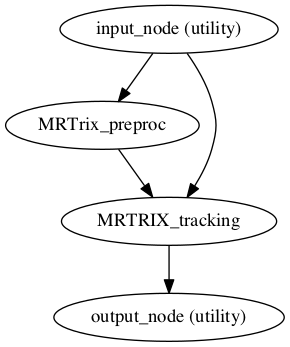

In [14]:
#wf.write_graph(dotfilename="workflow_graph.dot", graph2use='orig')
#wf.write_graph?
#from IPython.display import Image
#Image(filename="workflow_graph.dot.png")